# SDID: Staggered Adoption and Inference

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Chapter 25 | Notebook 3 of 3**

This notebook covers inference for SDID using placebo variance estimation,
and extends to staggered adoption settings with multiple treatment cohorts.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

# Additional imports
import cvxpy as cp
from joblib import Parallel, delayed
from scipy.stats import norm

---

## 1. Intuition {#intuition}

### The Inference Challenge

SDID produces a point estimate, but how do we construct confidence intervals?

**Challenges:**
1. Weights are estimated (not known)
2. Few treated units → asymptotic theory may not apply
3. Clustering structure unknown

**Solution: Placebo Variance Estimation**

The key insight: estimate variance by applying SDID to **control units as if treated**.

> For each control unit $j$:
> 1. Pretend unit $j$ was treated
> 2. Use remaining controls to estimate "placebo effect"
> 3. Under null (no effect), placebo effects should be noise
> 4. Use variance of placebos to estimate SE

### Staggered Adoption

In many applications, treatment rolls out over time:

| Unit | 2015 | 2016 | 2017 | 2018 | 2019 |
|------|------|------|------|------|------|
| A    |  0   |  0   |  1   |  1   |  1   |
| B    |  0   |  0   |  0   |  1   |  1   |
| C    |  0   |  0   |  0   |  0   |  1   |
| D    |  0   |  0   |  0   |  0   |  0   |

**SDID with staggered adoption:**
1. Apply SDID separately for each treatment cohort
2. Pool estimates using inverse-variance weighting
3. Account for using treated units as controls for later cohorts

---

## 2. Formal Treatment {#formal}

### 2.1 Placebo Variance Estimator

For each control unit $j \in \{1, ..., N_{co}\}$:

1. Treat unit $j$ as if it were treated
2. Estimate SDID using remaining $N_{co} - 1$ controls
3. Compute placebo estimate $\hat{\tau}_j^{placebo}$

The variance estimator:

$$\hat{V}^{placebo} = \frac{N_{co}}{N_{co} - 1} \cdot \frac{1}{N_{co}} \sum_{j=1}^{N_{co}} (\hat{\tau}_j^{placebo})^2$$

Under the null hypothesis of no treatment effect:
- True placebo effects are zero
- Estimated placebos reflect sampling variance
- $\sqrt{\hat{V}^{placebo}}$ estimates the standard error

### 2.2 Confidence Intervals

The $(1-\alpha)$ confidence interval:

$$\hat{\tau}^{sdid} \pm z_{1-\alpha/2} \cdot \sqrt{\hat{V}^{placebo}}$$

**Notes:**
1. Uses normal approximation (may need adjustment for small $N_{co}$)
2. Placebo variance accounts for weight estimation uncertainty
3. Valid under assumption that placebo units behave like treated unit

### 2.3 Staggered Adoption Estimator

With cohorts $g \in \{g_1, ..., g_K\}$ (treatment timing):

1. For each cohort $g$, define:
   - Treated units: Units first treated at time $g$
   - Control units: Units not yet treated by time $g$
   
2. Estimate cohort-specific effect: $\hat{\tau}_g^{sdid}$

3. Aggregate:
$$\hat{\tau}^{staggered} = \sum_g \omega_g \hat{\tau}_g^{sdid}$$

Where weights $\omega_g$ can be:
- **Sample size**: $\omega_g \propto N_{tr,g}$
- **Inverse variance**: $\omega_g \propto 1/\hat{V}_g$
- **Post-treatment periods**: $\omega_g \propto T_{post,g}$

---

## 3. Numeric Demonstration {#numeric}

### Load Data and Setup

In [2]:
# Load smoking data
cigar = load_facure_data("smoking.csv")

# Setup
calif_state = 3
treatment_year = 1989

# Pivot to wide format
Y_wide = cigar.pivot(index='state', columns='year', values='cigsale')

# Extract blocks
pre_years = [y for y in Y_wide.columns if y < treatment_year]
post_years = [y for y in Y_wide.columns if y >= treatment_year]

Y_co_pre = Y_wide.loc[Y_wide.index != calif_state, pre_years].values
Y_co_post = Y_wide.loc[Y_wide.index != calif_state, post_years].values
Y_tr_pre = Y_wide.loc[calif_state, pre_years].values
Y_tr_post = Y_wide.loc[calif_state, post_years].values

control_states = Y_wide.index[Y_wide.index != calif_state].values
N_co, T_pre = Y_co_pre.shape
T_post = Y_co_post.shape[1]

print(f"Setup: {N_co} control states, {T_pre} pre-periods, {T_post} post-periods")

Setup: 38 control states, 19 pre-periods, 12 post-periods


### SDID Point Estimate

In [3]:
def sdid_estimate_full(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post, zeta=None):
    """
    Full SDID estimation with optional zeta specification.
    
    Returns tau, w, lambda, zeta
    """
    N_co, T_pre = Y_co_pre.shape
    T_post = Y_co_post.shape[1]
    N_tr = 1
    
    # Compute zeta if not provided
    if zeta is None:
        delta = np.diff(Y_co_pre, axis=1)
        sigma = np.std(delta, ddof=1)
        zeta = (N_tr * T_post) ** 0.25 * sigma
    
    # Unit weights
    X_unit = Y_co_pre.T
    y_unit = Y_tr_pre.flatten()
    
    w = cp.Variable(N_co)
    w0 = cp.Variable()
    pred = w0 + X_unit @ w
    obj = cp.Minimize(cp.sum_squares(pred - y_unit) + zeta**2 * T_pre * cp.sum_squares(w))
    prob = cp.Problem(obj, [cp.sum(w) == 1, w >= 0])
    prob.solve(solver=cp.OSQP, verbose=False)
    w_hat = w.value
    
    # Time weights
    y_target = Y_co_post.mean(axis=1)
    lam = cp.Variable(T_pre)
    lam0 = cp.Variable()
    pred_t = lam0 + Y_co_pre @ lam
    obj_t = cp.Minimize(cp.sum_squares(pred_t - y_target))
    prob_t = cp.Problem(obj_t, [cp.sum(lam) == 1, lam >= 0])
    prob_t.solve(solver=cp.OSQP, verbose=False)
    lam_hat = lam.value
    
    # SDID estimate
    Y_tr_post_mean = Y_tr_post.mean()
    Y_co_post_weighted = (Y_co_post.T @ w_hat).mean()
    Y_tr_pre_weighted = Y_tr_pre.flatten() @ lam_hat
    Y_co_pre_weighted = (Y_co_pre.T @ w_hat) @ lam_hat
    
    tau = (Y_tr_post_mean - Y_co_post_weighted) - (Y_tr_pre_weighted - Y_co_pre_weighted)
    
    return tau, w_hat, lam_hat, zeta

# Estimate SDID
tau_sdid, w_sdid, lam_sdid, zeta = sdid_estimate_full(
    Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post
)

print(f"SDID Point Estimate: {tau_sdid:.2f} packs/capita")

SDID Point Estimate: -15.61 packs/capita


### Placebo Variance Estimation

In [4]:
def placebo_estimate(j, Y_co_pre, Y_co_post, zeta):
    """
    Compute placebo SDID estimate treating control unit j as treated.
    
    Parameters
    ----------
    j : int
        Index of control unit to treat as placebo treated
    Y_co_pre : ndarray (N_co, T_pre)
        All control units pre-treatment
    Y_co_post : ndarray (N_co, T_post)
        All control units post-treatment
    zeta : float
        Regularization parameter (from main estimation)
        
    Returns
    -------
    tau_placebo : float
        Placebo treatment effect estimate
    """
    # Treat unit j as "treated"
    Y_placebo_tr_pre = Y_co_pre[j, :]
    Y_placebo_tr_post = Y_co_post[j, :]
    
    # Use remaining units as controls
    mask = np.ones(Y_co_pre.shape[0], dtype=bool)
    mask[j] = False
    Y_placebo_co_pre = Y_co_pre[mask, :]
    Y_placebo_co_post = Y_co_post[mask, :]
    
    # Estimate SDID with fixed zeta
    tau, _, _, _ = sdid_estimate_full(
        Y_placebo_tr_pre, Y_placebo_tr_post,
        Y_placebo_co_pre, Y_placebo_co_post,
        zeta=zeta
    )
    
    return tau

# Compute placebo estimates for all control units
print("Computing placebo estimates...")
placebo_effects = Parallel(n_jobs=-1)(
    delayed(placebo_estimate)(j, Y_co_pre, Y_co_post, zeta) 
    for j in range(N_co)
)
placebo_effects = np.array(placebo_effects)

print(f"Computed {len(placebo_effects)} placebo estimates")

Computing placebo estimates...


Computed 38 placebo estimates


In [5]:
# Placebo variance estimator
V_placebo = (N_co / (N_co - 1)) * np.mean(placebo_effects**2)
SE_placebo = np.sqrt(V_placebo)

# 95% confidence interval
alpha = 0.05
z_crit = norm.ppf(1 - alpha/2)
ci_lower = tau_sdid - z_crit * SE_placebo
ci_upper = tau_sdid + z_crit * SE_placebo

print(f"\nInference Results:")
print(f"  Point estimate: {tau_sdid:.2f}")
print(f"  Placebo SE: {SE_placebo:.2f}")
print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"  t-statistic: {tau_sdid / SE_placebo:.2f}")
print(f"  p-value: {2 * (1 - norm.cdf(abs(tau_sdid / SE_placebo))):.4f}")


Inference Results:
  Point estimate: -15.61
  Placebo SE: 9.50
  95% CI: [-34.23, 3.02]
  t-statistic: -1.64
  p-value: 0.1006


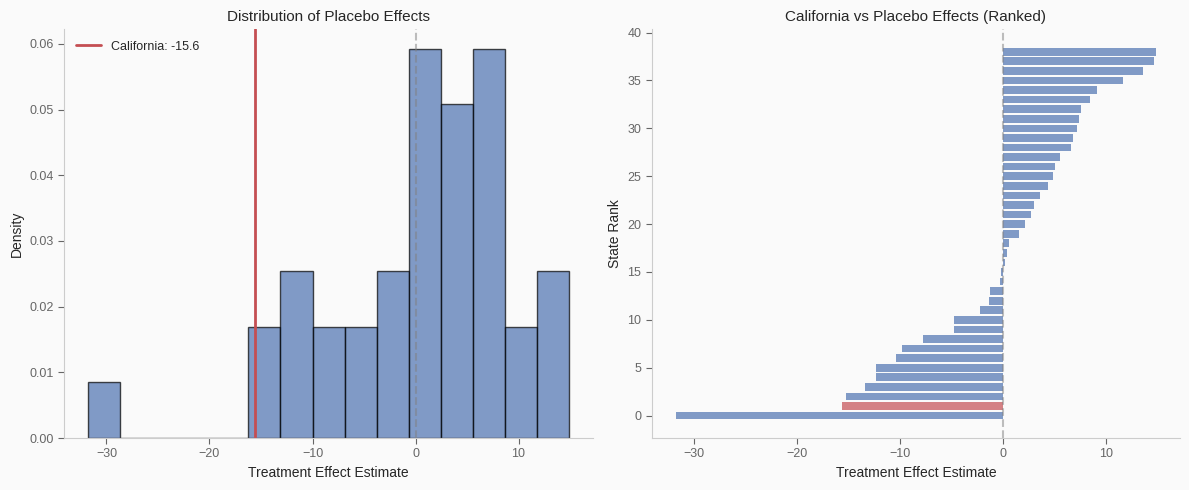


Fisher Exact Test:
  California rank: 2 / 39
  One-sided p-value: 0.0513


In [6]:
# Visualize placebo distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Histogram of placebos
ax = axes[0]
ax.hist(placebo_effects, bins=15, color=COLORS['blue'], alpha=0.7, 
        edgecolor='black', density=True)
ax.axvline(tau_sdid, color=COLORS['red'], linewidth=2, 
           label=f'California: {tau_sdid:.1f}')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Treatment Effect Estimate')
ax.set_ylabel('Density')
ax.set_title('Distribution of Placebo Effects')
ax.legend()
apply_tufte_style(ax)

# Right: Sorted placebo effects with California
ax = axes[1]
all_effects = np.concatenate([placebo_effects, [tau_sdid]])
all_labels = list(control_states) + ['California']
sort_idx = np.argsort(all_effects)

colors = [COLORS['red'] if all_labels[i] == 'California' else COLORS['blue'] 
          for i in sort_idx]
ax.barh(range(len(all_effects)), all_effects[sort_idx], color=colors, alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Treatment Effect Estimate')
ax.set_ylabel('State Rank')
ax.set_title('California vs Placebo Effects (Ranked)')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

# Fisher exact p-value
rank = np.sum(all_effects <= tau_sdid)
p_fisher = rank / len(all_effects)
print(f"\nFisher Exact Test:")
print(f"  California rank: {rank} / {len(all_effects)}")
print(f"  One-sided p-value: {p_fisher:.4f}")

---

## 4. Implementation {#implementation}

### Complete SDID Class with Inference

In [7]:
class SDIDWithInference:
    """
    SDID estimator with placebo-based inference.
    """
    
    def __init__(self, n_jobs=-1):
        self.n_jobs = n_jobs
        self.tau_ = None
        self.se_ = None
        self.placebo_effects_ = None
        self.zeta_ = None
        self.w_ = None
        self.lambda_ = None
        
    def fit(self, Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post):
        """
        Fit SDID and compute inference.
        """
        # Point estimate
        self.tau_, self.w_, self.lambda_, self.zeta_ = sdid_estimate_full(
            Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post
        )
        
        # Placebo inference
        N_co = Y_co_pre.shape[0]
        self.placebo_effects_ = np.array(Parallel(n_jobs=self.n_jobs)(
            delayed(placebo_estimate)(j, Y_co_pre, Y_co_post, self.zeta_)
            for j in range(N_co)
        ))
        
        # Variance estimate
        V = (N_co / (N_co - 1)) * np.mean(self.placebo_effects_**2)
        self.se_ = np.sqrt(V)
        
        return self
    
    def confidence_interval(self, alpha=0.05):
        """Return (1-alpha) confidence interval."""
        z = norm.ppf(1 - alpha/2)
        return self.tau_ - z * self.se_, self.tau_ + z * self.se_
    
    def pvalue(self, alternative='two-sided'):
        """P-value from normal approximation."""
        z = abs(self.tau_ / self.se_)
        if alternative == 'two-sided':
            return 2 * (1 - norm.cdf(z))
        else:
            return 1 - norm.cdf(z)
    
    def fisher_pvalue(self):
        """Fisher exact p-value from placebo distribution."""
        all_effects = np.concatenate([self.placebo_effects_, [self.tau_]])
        rank = np.sum(all_effects <= self.tau_)
        return rank / len(all_effects)
    
    def summary(self):
        """Print summary of results."""
        ci_low, ci_high = self.confidence_interval()
        print(f"SDID Estimation Results")
        print(f"=" * 40)
        print(f"Treatment Effect: {self.tau_:.4f}")
        print(f"Standard Error:   {self.se_:.4f}")
        print(f"95% CI:          [{ci_low:.4f}, {ci_high:.4f}]")
        print(f"t-statistic:     {self.tau_/self.se_:.4f}")
        print(f"p-value (normal): {self.pvalue():.4f}")
        print(f"p-value (Fisher): {self.fisher_pvalue():.4f}")
        print(f"=" * 40)

In [8]:
# Use the class
sdid_inf = SDIDWithInference(n_jobs=-1)
sdid_inf.fit(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post)
sdid_inf.summary()

SDID Estimation Results
Treatment Effect: -15.6054
Standard Error:   9.5048
95% CI:          [-34.2345, 3.0237]
t-statistic:     -1.6418
p-value (normal): 0.1006
p-value (Fisher): 0.0513


### Staggered Adoption Example

Let's simulate a staggered adoption scenario to demonstrate the methodology.

In [9]:
# Simulate staggered adoption data
np.random.seed(42)

N_units = 50
T_periods = 20
treatment_times = {15: 5, 17: 3}  # cohort: n_treated

# Generate base outcomes
unit_fe = np.random.normal(0, 2, N_units)
time_fe = np.cumsum(np.random.normal(0, 0.5, T_periods))
Y_base = unit_fe[:, None] + time_fe[None, :] + np.random.normal(0, 1, (N_units, T_periods))

# Assign treatment
treatment_status = np.zeros((N_units, T_periods), dtype=int)
cohort_assignment = np.zeros(N_units, dtype=int)  # 0 = never treated

idx = 0
for cohort, n_tr in treatment_times.items():
    for i in range(n_tr):
        treatment_status[idx, cohort:] = 1
        cohort_assignment[idx] = cohort
        idx += 1

# True treatment effects (heterogeneous by cohort)
true_effects = {15: -3.0, 17: -2.0}

# Add treatment effects
Y_obs = Y_base.copy()
for cohort, effect in true_effects.items():
    mask = cohort_assignment == cohort
    Y_obs[mask, cohort:] += effect

print(f"Simulated Data:")
print(f"  Total units: {N_units}")
print(f"  Never treated: {np.sum(cohort_assignment == 0)}")
print(f"  Cohort 15 (treated period 15+): {np.sum(cohort_assignment == 15)}, true effect: {true_effects[15]}")
print(f"  Cohort 17 (treated period 17+): {np.sum(cohort_assignment == 17)}, true effect: {true_effects[17]}")

Simulated Data:
  Total units: 50
  Never treated: 42
  Cohort 15 (treated period 15+): 5, true effect: -3.0
  Cohort 17 (treated period 17+): 3, true effect: -2.0


In [10]:
def sdid_staggered(Y_obs, cohort_assignment, cohort, treatment_time):
    """
    SDID for a single cohort in staggered setting.
    
    Uses not-yet-treated units as controls.
    """
    # Treated units: units in this cohort
    treated_mask = cohort_assignment == cohort
    
    # Control units: units not yet treated by treatment_time
    # (never treated OR treated later)
    control_mask = (cohort_assignment == 0) | (cohort_assignment > cohort)
    
    # Extract data
    Y_tr = Y_obs[treated_mask, :]
    Y_co = Y_obs[control_mask, :]
    
    # Split into pre/post
    Y_tr_pre = Y_tr[:, :treatment_time].mean(axis=0)  # Average across treated units
    Y_tr_post = Y_tr[:, treatment_time:].mean(axis=0)
    Y_co_pre = Y_co[:, :treatment_time]
    Y_co_post = Y_co[:, treatment_time:]
    
    # Estimate SDID
    tau, w, lam, zeta = sdid_estimate_full(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post)
    
    return tau, np.sum(treated_mask), np.sum(control_mask)

# Estimate effects for each cohort
cohort_results = {}
for cohort, true_effect in true_effects.items():
    tau, n_tr, n_co = sdid_staggered(Y_obs, cohort_assignment, cohort, cohort)
    cohort_results[cohort] = {
        'estimate': tau,
        'true': true_effect,
        'n_treated': n_tr,
        'n_control': n_co
    }

print(f"\nStaggered SDID Results:")
print(f"{'Cohort':<10} {'Estimate':<12} {'True':<10} {'N_tr':<8} {'N_co':<8}")
print("-" * 48)
for cohort, res in cohort_results.items():
    print(f"{cohort:<10} {res['estimate']:<12.2f} {res['true']:<10.2f} {res['n_treated']:<8} {res['n_control']:<8}")


Staggered SDID Results:
Cohort     Estimate     True       N_tr     N_co    
------------------------------------------------
15         -2.65        -3.00      5        45      
17         -2.19        -2.00      3        42      


In [11]:
# Aggregate estimate (inverse-variance weighted would require SE estimation)
# Here we use sample-size weighting for simplicity
total_treated = sum(r['n_treated'] for r in cohort_results.values())
tau_agg = sum(
    r['estimate'] * r['n_treated'] / total_treated 
    for r in cohort_results.values()
)
true_agg = sum(
    r['true'] * r['n_treated'] / total_treated 
    for r in cohort_results.values()
)

print(f"\nAggregated Estimate (sample-size weighted):")
print(f"  SDID: {tau_agg:.2f}")
print(f"  True: {true_agg:.2f}")


Aggregated Estimate (sample-size weighted):
  SDID: -2.48
  True: -2.62


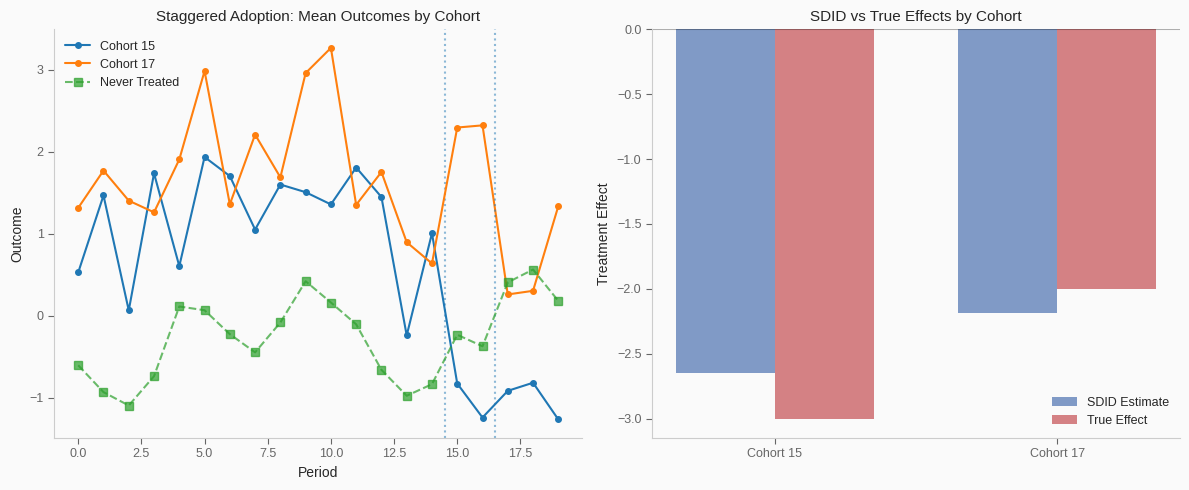

In [12]:
# Visualize staggered adoption
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Treatment rollout
ax = axes[0]
for cohort in sorted(treatment_times.keys()):
    mask = cohort_assignment == cohort
    Y_cohort = Y_obs[mask, :].mean(axis=0)
    ax.plot(range(T_periods), Y_cohort, 'o-', label=f'Cohort {cohort}', markersize=4)
    ax.axvline(cohort - 0.5, linestyle=':', alpha=0.5)

# Never treated
Y_never = Y_obs[cohort_assignment == 0, :].mean(axis=0)
ax.plot(range(T_periods), Y_never, 's--', label='Never Treated', alpha=0.7)

ax.set_xlabel('Period')
ax.set_ylabel('Outcome')
ax.set_title('Staggered Adoption: Mean Outcomes by Cohort')
ax.legend()
apply_tufte_style(ax)

# Right: Cohort-specific effects
ax = axes[1]
cohorts = list(cohort_results.keys())
estimates = [cohort_results[c]['estimate'] for c in cohorts]
trues = [cohort_results[c]['true'] for c in cohorts]

x = np.arange(len(cohorts))
width = 0.35
ax.bar(x - width/2, estimates, width, label='SDID Estimate', color=COLORS['blue'], alpha=0.7)
ax.bar(x + width/2, trues, width, label='True Effect', color=COLORS['red'], alpha=0.7)
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xticks(x)
ax.set_xticklabels([f'Cohort {c}' for c in cohorts])
ax.set_ylabel('Treatment Effect')
ax.set_title('SDID vs True Effects by Cohort')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

---

## 5. Interview Appendix {#interview}

### Q1: Why use placebo variance instead of bootstrap for SDID inference?

<details>
<summary>Solution</summary>

**Key points:**

1. **Few treated units**: Bootstrap requires resampling treated units. With
   one treated unit (California), bootstrap doesn't apply directly.

2. **Weight estimation**: Placebo approach naturally accounts for weight
   estimation uncertainty by re-estimating weights for each placebo.

3. **Fisher tradition**: Placebo tests have long history in SC literature
   (Abadie et al. 2010). SDID extends this tradition.

4. **When bootstrap works**:
   - Multiple treated units
   - Block bootstrap over time
   - Wild bootstrap for dependent errors

</details>

### Q2: How does SDID handle staggered adoption compared to TWFE?

<details>
<summary>Solution</summary>

**Key points:**

1. **TWFE problem**: Standard TWFE uses already-treated units as implicit
   controls for later cohorts, causing bias with heterogeneous effects.

2. **SDID approach**: Estimate separately for each cohort, using only
   not-yet-treated units as controls.

3. **Aggregation**: Combine cohort-specific estimates with appropriate
   weights (sample size, inverse variance, or equal).

4. **Advantages**:
   - No forbidden comparisons (treated vs treated)
   - Allows heterogeneous effects by cohort
   - Transparent about what's being estimated

</details>

### Q3: What assumptions are needed for SDID inference to be valid?

<details>
<summary>Solution</summary>

**Key points:**

1. **Parallel trends (conditional)**: After reweighting, treated and synthetic
   control would have parallel trends absent treatment.

2. **Exchangeability**: Placebo units are exchangeable with treated unit
   under the null. This means:
   - Similar data generating process
   - No spillovers from actual treated unit

3. **No anticipation**: Units don't change behavior before treatment.

4. **SUTVA**: No interference between units.

5. **For normal CI**: Large enough $N_{co}$ for CLT to apply.

</details>

---

## 6. References {#references}

[^1]: Arkhangelsky, D., Athey, S., Hirshberg, D., Imbens, G., & Wager, S. (2021). 
      Synthetic Difference-in-Differences. *American Economic Review*, 111(12), 4088-4118.

[^2]: Abadie, A., Diamond, A., & Hainmueller, J. (2010). 
      Synthetic Control Methods for Comparative Case Studies. 
      *Journal of the American Statistical Association*, 105(490), 493-505.

[^3]: Callaway, B., & Sant'Anna, P. H. (2021). 
      Difference-in-Differences with Multiple Time Periods. 
      *Journal of Econometrics*, 225(2), 200-230.

[^4]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 25.